> **This notebook contains workings only**
***

#### Import and prepare high-frequency tick data for AAPL and JPM

In [1]:
# check GPU (if working on local machine)
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
# for running in docker image
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import pandas as pd
from volgpt_data import high_frequency_data
pd.set_option('display.width', 1000)  # Set pandas display width to 1000 characters

df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats = high_frequency_data()
missing_rows_AAPL = df_data_AAPL[df_data_AAPL.isnull().any(axis=1)] # Check for rows with missing values, AAPL
missing_rows_JPM = df_data_JPM[df_data_JPM.isnull().any(axis=1)] # Check for rows with missing values, JPM

print('df_data_AAPL.shape: ', df_data_AAPL.shape, '\n')
print('df_data_JPM.shape: ', df_data_JPM.shape, '\n')
if missing_rows_AAPL.shape[0] == 0:
    print("no missing_rows_AAPL rows with missing values")
else:
    print('missing AAPL rows: ', missing_rows_AAPL.shape, '\n') # print number of rows with missing values
if missing_rows_JPM.shape[0] == 0:
    print("no missing_rows_JPM rows with missing values")
else:
    print('missing JPM rows: ', missing_rows_JPM.shape, '\n') # print number of rows with missing values

df_data_AAPL.head(10)


df_data_AAPL.shape:  (533860, 9) 

df_data_JPM.shape:  (537011, 9) 

no missing_rows_AAPL rows with missing values
no missing_rows_JPM rows with missing values


,Ticker,CloseBidSize,CloseAskSize,CloseBidPrice,CloseAskPrice,DateTime,WeightedMidPrice,AAPL_rr,AAPL_lr
961,AAPL,100.0,2300.0,280.18,280.99,2019-12-18 04:00:00,280.21,UNK,UNK
962,AAPL,100.0,2300.0,280.03,280.99,2019-12-18 04:01:00,280.07,-0.14,-0.0
963,AAPL,100.0,100.0,280.03,280.9,2019-12-18 04:02:00,280.46,0.4,0.0
964,AAPL,100.0,100.0,280.03,280.9,2019-12-18 04:03:00,280.46,0.0,0.0
965,AAPL,100.0,100.0,280.03,280.65,2019-12-18 04:04:00,280.34,-0.12,-0.0
966,AAPL,100.0,100.0,280.08,280.65,2019-12-18 04:05:00,280.36,0.03,0.0
967,AAPL,100.0,100.0,280.08,280.67,2019-12-18 04:06:00,280.38,0.01,0.0
968,AAPL,100.0,100.0,280.03,280.38,2019-12-18 04:07:00,280.2,-0.17,-0.0
969,AAPL,100.0,100.0,280.03,280.38,2019-12-18 04:08:00,280.2,0.0,0.0
970,AAPL,100.0,100.0,280.03,280.38,2019-12-18 04:09:00,280.2,0.0,0.0


#### Descriptive statistics

In [4]:
# Descriptive statistics
from scipy import stats

print("Descriptive statistics for AAPL: ","\n"
      "Number of observations = ",AAPL_stats.nobs,"\n"
      "Minimum, Maximum = ", str(AAPL_stats.minmax),"\n"
      "Mean = %.5f" %  AAPL_stats.mean,"\n"
      "Variance = %.5f" %  AAPL_stats.variance,"\n"
      "Standard deviation = %.5f" %  AAPL_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  AAPL_stats.skewness,"\n"
      "Kurtosis = %.5f" %  AAPL_stats.kurtosis,"\n") 

print("Descriptive statistics for JPM: ","\n"
      "Number of observations = ",JPM_stats.nobs,"\n"
      "Minimum, Maximum = ", str(JPM_stats.minmax),"\n"
      "Mean = %.5f" %  JPM_stats.mean,"\n"
      "Variance = %.5f" %  JPM_stats.variance,"\n"
      "Standard deviation = %.5f" %  JPM_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  JPM_stats.skewness,"\n"
      "Kurtosis = %.5f" %  JPM_stats.kurtosis)

Descriptive statistics for AAPL:  
Number of observations =  444470 
Minimum, Maximum =  (-152.83124999999998, 165.5690434782609) 
Mean = -0.00017 
Variance = 4.54474 
Standard deviation = 2.13184 
Skewness = 1.33822 
Kurtosis = 2684.83480 

Descriptive statistics for JPM:  
Number of observations =  332093 
Minimum, Maximum =  (-39.10681818181817, 50.888157894736835) 
Mean = -0.00007 
Variance = 0.38692 
Standard deviation = 0.62203 
Skewness = -1.59559 
Kurtosis = 1684.46534


#### Plot raw returns and log returns

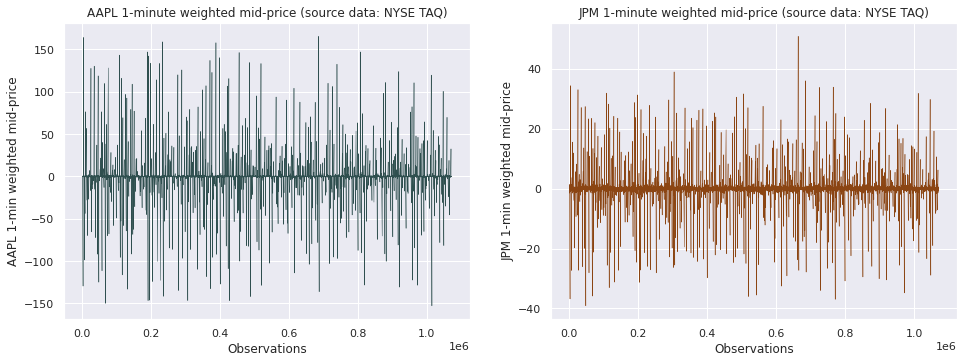

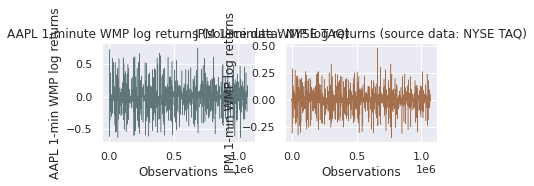

In [5]:
# Returns plots
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

fig = plt.figure(figsize=(16,12))  

ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(AAPL_rr, color='darkslategrey', linewidth=0.5)

ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(JPM_rr, color='saddlebrown', linewidth=0.5)

plt.show();

# Log returns plots
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(AAPL_lr, color='darkslategrey', linewidth=0.5, alpha=0.75)

ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(JPM_lr, color='saddlebrown', linewidth=0.5, alpha=0.75)

plt.show();

In [6]:
unique_values = df_data_AAPL['WeightedMidPrice'].unique()
print("Unique values in 'WeightedMidPrice' field:")
print(unique_values)


Unique values in 'WeightedMidPrice' field:
['280.21' '280.07' '280.46' ... '148.94' '149.58' '146.53']


In [8]:
df_data_AAPL['WeightedMidPrice'] = pd.to_numeric(df_data_AAPL['WeightedMidPrice'], errors='coerce')


# plot returns from scratch

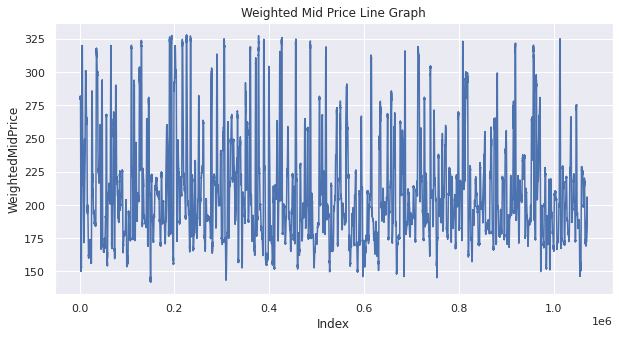

In [9]:
    plt.figure(figsize=(10, 5))
    plt.plot(df_data_AAPL['WeightedMidPrice'])
    plt.xlabel('Index')
    plt.ylabel('WeightedMidPrice')
    plt.title('Weighted Mid Price Line Graph')
    plt.show()

# plot returns using v0.1.5 code

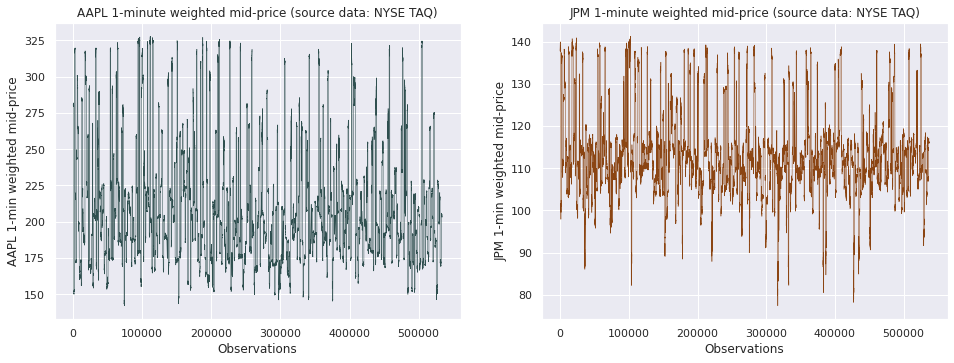

In [10]:
# Returns plots
from datetime import datetime, timedelta, date
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

# df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats = high_frequency_data()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

fig = plt.figure(figsize=(16,12))  

j = df_data_AAPL['WeightedMidPrice']
j = pd.to_numeric(df_data_AAPL['WeightedMidPrice'], errors='coerce')  # convert to numeric to avoid problem with UNK values
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(j, color='darkslategrey', linewidth=0.5)

j = df_data_JPM
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(j, color='saddlebrown', linewidth=0.5)

plt.show();


In [11]:
# Log returns plots
from scipy import stats
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(16,12))  

# Log returns (NB: shown without removal of outliers)
AAPL_lr = df_data.loc[df_data['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = df_data.loc[df_data['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

j = np.array(AAPL_lr).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(j, color='darkslategrey', linewidth=0.5, alpha=0.75)

j = np.array(JPM_lr).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(j, color='saddlebrown', linewidth=0.5, alpha=0.75)

plt.show();

NameError: name 'df_data' is not defined

<Figure size 1152x864 with 0 Axes>

#### Create text file for input to NanoGPT

In [12]:
# save df_data_AAPL and df_data_JPM as a text file with a comma delimiter

df_data_AAPL.to_csv('df_data_AAPL.txt', sep=',', index=False)
df_data_JPM.to_csv('df_data_JPM.txt', sep=',', index=False)

#### From ChatGPT re structure of text file:

> "In this example, we first create a sample dataframe called df. We then use the to_csv method to save the dataframe to a file called data.txt. The sep parameter specifies the delimiter to use in the text file (in this case, a tab character), and the index parameter is set to False to exclude the index from the output.  You can customize the parameters of to_csv method as per your requirements."

#### My next prompt: 

> I shall use data.txt as an input to a large language model (Karpathy's NanoGPT).  Should I include the sep='/t' parameter?

#### ChatGPT:

> "Yes, you should include the sep='\t' parameter in the to_csv method to specify the delimiter as a tab character. <br> <br>
> If the input file for Karpathy's NanoGPT expects tab-separated values, you need to ensure that the file you're providing is also in the same format. In the example I provided earlier, the sep='\t' parameter specifies that the data will be saved as tab-separated values. <br> <br>
> Therefore, including this parameter will ensure that the saved text file has a tab-separated format, which is the expected format for input to Karpathy's NanoGPT."

# MODIFY volgpt_data.py SO THAT df_data_AAPL and df_data_JPM CONTAIN ON THE COLUMNS FOR RAW RETURNS AND LOG RETURNS THAT ARE RELEVANT TO APPL AND JPM RESPECTIVELY

# SHAPES BELOW ARE WRONG - SEE DESCRIPTIVE STATISTICS ABOVE

In [13]:
# Check that the text file was saved correctly

df_exported_AAPL = pd.read_csv('df_data_AAPL.txt', sep=',') # read the text file into a dataframe
df_exported_JPM = pd.read_csv('df_data_JPM.txt', sep=',') # read the text file into a dataframe

print('shape of df_data_AAPL: ', df_data_AAPL.shape)
print('shape of df_exported_AAPL: ', df_exported_AAPL.shape)
print('shape of df_data_AAPL: ', df_data_AAPL.shape)
print('shape of df_exported_AAPL: ', df_exported_AAPL.shape)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


shape of df_data_AAPL:  (533860, 9)
shape of df_exported_AAPL:  (533860, 9)
shape of df_data_AAPL:  (533860, 9)
shape of df_exported_AAPL:  (533860, 9)


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Load data into NanoGPT

#### __[See nanogpt/nanogpt.ipynb commit v0.1.18 for consolidated code](https://github.com/johncollinsai/nanogpt/blob/bc54688a22dbce92648ad36fec865140ab1d6544/nanogpt.ipynb)__

# NOTE ONLY WORKING ON AAPL FOR NOW ... NEED TO INCLUDE JPM, PERHAPS AFTER MOVING MODEL TO A PYTHON FILE?

# Generate tick data

The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable pred.

> I generate 10k tokens, and then decode the tokens into a string. The output string, pred, contains a list of financial data points, including stock names (e.g., AAPL, JPM), timestamps, and the various numerical values. Each row of data starts with the stock symbol (e.g., AAPL or JPM), followed by a timestamp (e.g., 10:01:00.000000000 or 17:19:00.000000000). After the timestamp, the other data are separated by commas. 

In [15]:
from nanogpt import train_and_generate

# Call the function with the desired parameters
train_and_generate('df_data_AAPL.txt', max_iters=5000, learning_rate=1e-3) # pass the path to the text file


# ****************************************************
# HOW DOES WHAT I AM CALLING NOW RELATE TO WHAT I WAS CALLING BEFORE? SEE IMMEDIATELY BELOW
# generate 10k tokens from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# pred = decode(m.generate(context, max_new_tokens=10000)[0].tolist())
# print(pred)


0.207149 M parameters
step 0: train loss 3.9742, val loss 3.9674
step 100: train loss 1.6732, val loss 1.6617
step 200: train loss 1.2507, val loss 1.2281
step 300: train loss 1.0291, val loss 1.0145
step 400: train loss 0.9649, val loss 0.9589
step 500: train loss 0.9164, val loss 0.9183
step 600: train loss 0.9033, val loss 0.8999
step 700: train loss 0.8974, val loss 0.8876
step 800: train loss 0.8817, val loss 0.8779
step 900: train loss 0.8680, val loss 0.8548
step 1000: train loss 0.8661, val loss 0.8597
step 1100: train loss 0.8645, val loss 0.8573
step 1200: train loss 0.8537, val loss 0.8552
step 1300: train loss 0.8523, val loss 0.8525
step 1400: train loss 0.8473, val loss 0.8449
step 1500: train loss 0.8478, val loss 0.8388
step 1600: train loss 0.8428, val loss 0.8388
step 1700: train loss 0.8375, val loss 0.8286
step 1800: train loss 0.8325, val loss 0.8337
step 1900: train loss 0.8235, val loss 0.8142
step 2000: train loss 0.8186, val loss 0.8123
step 2100: train loss 0.

In [16]:
# obtain pred from the function
pred = train_and_generate('df_data_AAPL.txt', max_iters=10000, learning_rate=1e-3) # pass the path to the text file

0.207149 M parameters
step 0: train loss 3.9742, val loss 3.9674
step 100: train loss 1.6732, val loss 1.6617
step 200: train loss 1.2507, val loss 1.2281
step 300: train loss 1.0291, val loss 1.0145
step 400: train loss 0.9649, val loss 0.9589
step 500: train loss 0.9164, val loss 0.9183
step 600: train loss 0.9033, val loss 0.8999
step 700: train loss 0.8974, val loss 0.8876
step 800: train loss 0.8817, val loss 0.8779
step 900: train loss 0.8680, val loss 0.8548
step 1000: train loss 0.8661, val loss 0.8597
step 1100: train loss 0.8645, val loss 0.8573
step 1200: train loss 0.8537, val loss 0.8552
step 1300: train loss 0.8523, val loss 0.8525
step 1400: train loss 0.8473, val loss 0.8449
step 1500: train loss 0.8478, val loss 0.8388
step 1600: train loss 0.8428, val loss 0.8388
step 1700: train loss 0.8375, val loss 0.8286
step 1800: train loss 0.8325, val loss 0.8337
step 1900: train loss 0.8235, val loss 0.8142
step 2000: train loss 0.8186, val loss 0.8123
step 2100: train loss 0.

# SEE CHATGPT "MZ regression for Stocks" for the next steps. 

In [17]:
# Evaluate the model using MZ regression
from mz import perform_mz_regression
df, df_clean, rr_results, lr_results = perform_mz_regression(pred)

print("Original DataFrame:")
print(df)

print("\nCleaned DataFrame:")
print(df_clean)

print("MZ Regression for rr:")
print(rr_results.summary())

print("\nMZ Regression for lr:")
print(lr_results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const               float64
WeightedMidPrice      int64
dtype: object. The data was
Series([], Name: rr, dtype: object)
and
 Empty DataFrame
Columns: [const, WeightedMidPrice]
Index: []
before. After,
[]
[].

# NEXT STEPS | TUESDAY

> * Compute MZ regressions using GPT4
> * Visualizations

# Compare to GPT4

# Visualize the results

***
# End